In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',delimiter=',',encoding='latin-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.shape

(5572, 2)

Text(0.5, 1.0, 'Number of ham and spam messages')

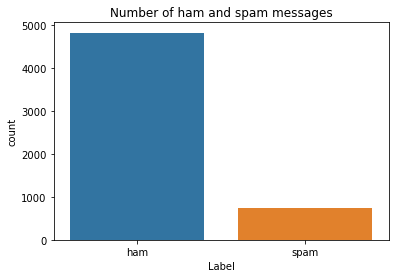

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [6]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [7]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [8]:
text_cleaning_re = "@\S+|A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
from sklearn.preprocessing import LabelEncoder
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.15)

In [12]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [13]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [15]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [16]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 5s 159ms/step - loss: 0.3067 - accuracy: 0.8878 - val_loss: 0.1508 - val_accuracy: 0.9515
Epoch 2/10
30/30 [==============================] - 4s 137ms/step - loss: 0.0780 - accuracy: 0.9802 - val_loss: 0.0571 - val_accuracy: 0.9842
Epoch 3/10
30/30 [==============================] - 4s 149ms/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0512 - val_accuracy: 0.9831
Epoch 4/10
30/30 [==============================] - 4s 137ms/step - loss: 0.0292 - accuracy: 0.9926 - val_loss: 0.0880 - val_accuracy: 0.9747


In [17]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [18]:
accr = model.evaluate(test_sequences_matrix,y_test)

27/27 [==============================] - 1s 19ms/step - loss: 0.0912 - accuracy: 0.9725


In [19]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.091
  Accuracy: 0.972
